<a href="https://colab.research.google.com/github/rachitgithub/Covid-Detection/blob/main/COVID19Training_MSRESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install TensorFlow GPU**

In [ ]:
!pip install tensorflow-gpu

# **Import GDRIVE**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Tensor Flow**

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()
print(tf.__version__)

2.3.0


# **Import Keras Libraries**

In [8]:
from keras.models import load_model
from keras.layers import Activation,Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive

from keras.applications.resnet50 import ResNet50
from keras.models import Model

# **Build MSRESNET CNN Model**


In [5]:
%%time
def Build_CNN_Model():   
    # -------------------------------------------------------------------------
    #                        MS RESNET  Model 
    # -------------------------------------------------------------------------
    # load ResNet model
    ResNet = ResNet50(include_top=True, input_shape=(224, 224, 3))
     
    # mark loaded layers as not trainable
    for layer in ResNet.layers:
	    layer.trainable = False        

    # mark loaded layers as trainable
    for layer in ResNet.layers[100:]:
	    layer.trainable = True 
    
    #  Softmax Classifier
    Class_layer = Dense(2)(ResNet.layers[-2].output)
    
    Softmax_layer = Activation('softmax')(Class_layer)
        
	# define new model    
    model = Model(inputs=ResNet.inputs, outputs=Softmax_layer)
            
    #  Display model
    model.summary()
    
	# compile model

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model 


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


# **Train MSRESNET CNN Model**


In [6]:
%%time
# train and evaluate cnn model
def Train_CNN_Model(model):
    
    # -------------------------------------------------------------------------
    #                        Train CNN Model 
    # -------------------------------------------------------------------------
    
     # create data generators    
    train_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,                                     
                                     brightness_range=[0.2,1.0],
                                     )
    
    valid_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
  
   
    # prepare iterators
    batch_size=32
    train_it = train_datagen.flow_from_directory('/content/drive/MyDrive/COVID-19-Deep-Learning-Project-Colab/Dataset/train/',classes =('Normal','Covid'),batch_size=batch_size, target_size=(224, 224))
    valid_it = valid_datagen.flow_from_directory('/content/drive/MyDrive/COVID-19-Deep-Learning-Project-Colab/Dataset/val/',classes =('Normal','Covid'),batch_size=batch_size, target_size=(224, 224))


    epochs=100;
    
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=valid_it, validation_steps=len(valid_it), epochs=epochs, verbose=1)
    
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

	# save model
    model.save('/content/drive/MyDrive/COVID-19-Deep-Learning-Project-Colab/saved_models/CoVID19-RESNET_cnn_model.h5')


CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.44 µs


# **Evaluate MSRESNET CNN Model**


In [9]:
def Evaluate_CNN_Model():
    # -------------------------------------------------------------------------
    #                        Evaluate CNN Model 
    # -------------------------------------------------------------------------
    
    # load model
    model = load_model('/content/drive/MyDrive/COVID-19-Deep-Learning-Project-Colab/saved_models/CoVID19-RESNET_cnn_model.h5')

    
     # load test data
    batch_size=32
    test_datagen = ImageDataGenerator(
                                     rescale=1.0/255.0,
                                     featurewise_center= True,
                                     featurewise_std_normalization = True)
    
    test_it = test_datagen.flow_from_directory('/content/drive/MyDrive/COVID-19-Deep-Learning-Project-Colab/Dataset/test/',classes =('Normal','Covid'), 
                                               shuffle=False,batch_size=batch_size, target_size=(224, 224))
    
    
    y_true = test_it.classes;

    y_pred = model.predict_generator(test_it, steps=len(test_it), verbose=1)

    
    y_pred_prob = y_pred[:,1]

     
    y_pred_binary =  y_pred_prob > 0.5
   
    #Confution Matrix    
    print('\nConfusion Matrix\n -------------------------')    
    print(confusion_matrix(y_true,y_pred_binary));
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred_binary)
    print('Accuracy: %f' % accuracy)
    
    
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred_binary)
    print('Precision: %f' % precision)
    
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred_binary)
    print('Recall: %f' % recall)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred_binary)
    print('F1 score: %f' % f1)    
       
    # ROC AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    print('ROC AUC: %f' % auc)
    
    
    # calculate roc curves
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        
    # plot the roc curve for the model
    plt.figure()
    plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')
    
    # axis labels
    plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
    plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')
       
    # show the legend
    plt_False_Positive_vs_True_Positive.legend()
    # show the plot
    plt_False_Positive_vs_True_Positive.show() 

          #for plotting CM graph
    cm = confusion_matrix(y_true,y_pred_binary)

    def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix for RESNET CNN',
                        cmap=plt.cm.tab20b):
 
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Values')
    plt.xlabel('True Values')
    cm_plot_labels = ['No Covid','Has Covid']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix for RESNET CNN')

    

102973440/102967424 [==============================] - 4s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
58/58 [==============================] - 1637s 28s/step - loss: 0.9027 - accuracy: 0.5341 - val_loss: 425.1514 - val_accuracy: 0.5054
Epoch 2/100
58/58 [==============================] - 110s 2s/step - loss: 0.5783 - accuracy: 0.7356 - val_loss: 18282.9082 - val_accuracy: 0.5054
Epoch 3/100
58/58 [==============================] - 110s 2s/step - loss: 0.4537 - accuracy: 0.7941 - val_loss: 3015.7510 - val_accuracy: 0.5054
Epoch 4/100
58/58 [==============================] - 110s 2s/step - loss: 0.3743 - accuracy: 0.8402 - val_loss: 1248.8539 - val_accuracy: 0.5054
Epoch 5/100
58/58 [==============================] - 110s 2s/step - loss: 0.3463 - accuracy: 0.8548 - val_loss: 95.4748 - val_accuracy: 0.5054
Epoch 6/100
58/58 [==============================] - 110s 2s/step - loss: 0.3911 - accuracy: 0.8348 - val_loss: 506.7516 - val_accuracy: 0.5054
Epoch 7/100
58/58 [==============================] - 110s 2s/step - loss: 0.3253 - accuracy: 0.8640 - val_loss: 313.4359 - val_accu

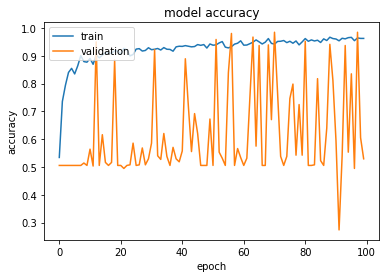

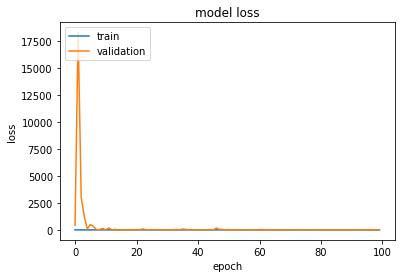

CPU times: user 3h 4min 3s, sys: 9min 49s, total: 3h 13min 53s
Wall time: 3h 31min 28s


In [8]:
%%time
model = Build_CNN_Model()

Train_CNN_Model(model)

In [10]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

Found 139 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


5/5 [==============================] - 25s 5s/step


No handles with labels found to put in legend.



Confusion Matrix
 -------------------------
[[ 8 62]
 [ 0 69]]
Accuracy: 0.553957
Precision: 0.526718
Recall: 1.000000
F1 score: 0.690000
ROC AUC: 0.961698


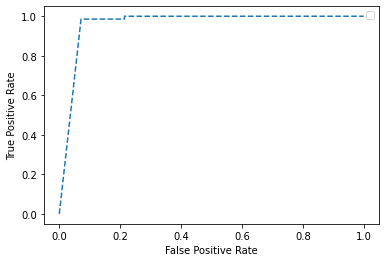

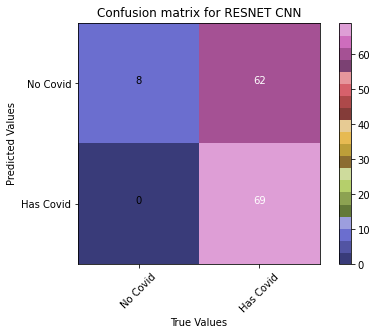

In [11]:
Evaluate_CNN_Model()